**Executed:** Sat Apr  8 15:23:13 2017

**Duration:** 15 seconds.

# Example - 2CDE Method

*This notebook is part of smFRET burst analysis software [FRETBursts](http://tritemio.github.io/FRETBursts/).*

> This notebook implements the 2CDE method from [Tomov 2012](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025).
>
> For a complete tutorial on burst analysis see 
> [FRETBursts - us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).

# Load Data

In [1]:
from fretbursts import *
from fretbursts.phtools import phrates
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.6.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
import fretbursts as fb

In [3]:
url = 'http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


In [4]:
filename = "data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"

In [5]:
d = loader.photon_hdf5(filename)
#bpl.plot_alternation_hist(d)
loader.alex_apply_period(d)
d.calc_bg(fun=bg.exp_fit, time_s=20, tail_min_us='auto', F_bg=1.7)
d.burst_search()

# Total photons (after ALEX selection):   2,259,522
#  D  photons in D+A excitation periods:    721,537
#  A  photons in D+A excitation periods:  1,537,985
# D+A photons in  D  excitation period:   1,434,842
# D+A photons in  A  excitation period:     824,680

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


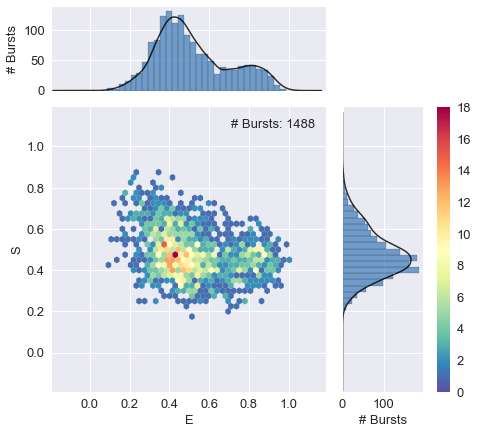

In [6]:
ds1 = d.select_bursts(select_bursts.size, th1=30)
ds = ds1.select_bursts(select_bursts.naa, th1=30)

alex_jointplot(ds)

In [7]:
ph = d.ph_times_m[0]

In [8]:
tau = 100e-6/d.clk_p
tau

8000.000000000001

# KDE considerations

In computing a KDE, the kernel can have different shapes. In the original
2CDE publication the "laplace distribution" kernel is used.

In the next sections we will show the 2CDE results
using both "laplace distribution" Gaussian kernel.

Here, we simply plot the two kernels for comparison:

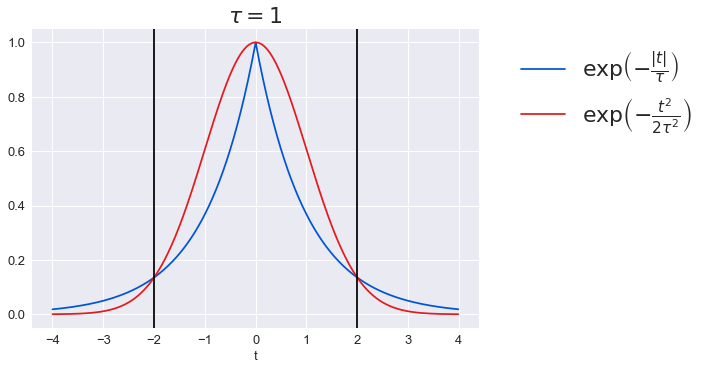

In [9]:
tau = 1
tau2 = 2 * (tau**2)

xx = np.arange(-4*tau, 4*tau, tau/100.)
y1 = np.exp(-np.abs(xx) / tau)
y2 = np.exp(-xx**2 / tau2)

plt.plot(xx,y1, label=r'$\exp \left( - \frac{|t|}{\tau} \right)$')
plt.plot(xx, y2, label=r'$\exp \left( - \frac{t^2}{2\tau^2} \right)$')
plt.axvline(2*tau, color='k')
plt.axvline(-2*tau, color='k')
plt.xlabel('t')
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 1), loc=2)
plt.title(r'$\tau = %d$' % tau, fontsize=22);

## Notes on Kernel Shape

The Gaussian kernel gives a more accurate rate estimation with very little dependence on the position where the KDE is evaluated. On the contrary, with symmetric exponential kernel (laplace distribution), there is always a strong dependence on the evaluation position. In particular, when rates are estimated at the timestamps positions, the rates are systematically over-estimated (i.e. the peak is always sampled).

For Gaussian kernel, given a $\tau$, the rate estimation will be accurate for rates higher than $1/(2\,\tau)$ counts-per-second. For lower rates, the estimation will strongly depend on where the KDE is evaluated. A similar condition can be also found for the exponential kernel, but this case the rate will aways be strongly dependent on the position.

# 2CDE

## KDE and nbKDE Definitions

Following Tomov 2012 notation, we define *KDE* as ([Tomov 2012, eq. 4](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$KDE_{X_i}^Y \left(t_{(CHX)_i}, t_{\{CHY\}} \right) = 
\sum_j^{N_{CHY}} \exp \left( - \frac{\lvert t_{(CHX)_i} - t_{(CHY)_j} \rvert}{\tau}\right) $$

and *nbKDE* as ([Tomov 2012, eq. 5](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$nbKDE_{X_i}^X \left(t_{\{CHX\}} \right) = \left(1 + \frac{2}{N_{CHX}} \right) \cdot
\sum_{j, \;j\ne i}^{N_{CHX}} \exp \left( - \frac{\lvert t_{(CHX)_i} - t_{(CHX)_j} \rvert}{\tau}\right) $$

These quantities can be computed for any slice of the timestamp arrays. 
In the implementation of *FRET-2CDE*, they will be compute on slices of
timestamps corresponding to each burst. 
In this context, $N_{CHX}$, (in the multiplicative correction factor of nbKDE), 
is the number of photons in the current burst (selecting only photons in the $X$ channel).

## FRET-2CDE Definition

To compute FRET-2CDE we need to define ([Tomov 2012, eq. 6](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$(E)_D = \frac{1}{N_{CHD}} \sum_{i=1}^{N_{CHD}} \frac{KDE_{Di}^A}{KDE_{Di}^A + nbKDE_{Di}^D} $$

and the symmetric estimator ([Tomov 2012, eq. 7](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$(1 - E)_A = \frac{1}{N_{CHA}} \sum_{i=1}^{N_{CHA}} \frac{KDE_{Ai}^D}{KDE_{Ai}^D + nbKDE_{Ai}^A} $$

Then *FRET-2CDE* is defined as ([Tomov 2012, eq. 8](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$ FRET-2CDE \left( t_{CHD}, t_{CHA} \right) = 
110 - 100 \cdot \left[ (E)_D + (1 - E)_A \right]
$$

These quantities are computed for each burst, so that $N_{CHD}$ ($N_{CHA}$) are
the number of photons in the DexDem (AemDex) channel during current burst.

## FRET-2CDE Functions

To implement the *FRET-2CDE*, we use the following FRETBursts function:

- `phrates.kde_laplace()` ([documentation](http://fretbursts.readthedocs.org/en/latest/phrates.html#fretbursts.phtools.phrates.kde_laplace))

This function computes the local photon rate using KDE with a [laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) kernel. 
FRETBursts provides similar functions to use a Gaussian or rectangular kernel ([kde_gaussian](http://fretbursts.readthedocs.org/en/latest/phrates.html#fretbursts.phtools.phrates.kde_gaussian) and
[kde_rect](http://fretbursts.readthedocs.org/en/latest/phrates.html#fretbursts.phtools.phrates.kde_rect)
respectively).

Here we define two functions to compute *FRET-2CDE* using the **laplace kernel**
(as in the original paper) and **Gaussian kernel**:

In [10]:
def calc_fret_2cde(tau, ph, mask_d, mask_a, bursts):
    """
    Compute FRET-2CDE for each burst.

    FRET-2CDE is a quantity that tends to be around 10 for bursts which have no
    dynamics, while it has larger values (e.g. 30..100) for bursts with
    millisecond dynamics.

    References:
        Tomov et al. BJ (2012) doi:10.1016/j.bpj.2011.11.4025

    Arguments:
        tau (scalar): time-constant of the exponential KDE
        ph (1D array): array of all-photons timestamps.
        mask_d (bool array): mask for DexDem photons
        mask_a (bool array): mask for DexAem photons
        bursts (Bursts object): object containing burst data
            (start-stop indexes are relative to `ph`).

    Returns:
        FRET_2CDE (1D array): array of FRET_2CDE quantities, one element
            per burst. This array contains NaN in correspondence of bursts
            containing to few photons to compute FRET-2CDE.
    """
    # Computing KDE burst-by-burst would cause inaccuracies at the burst edges.
    # Therefore, we first compute KDE on the full timestamps array and then
    # we take slices for each burst.
    # These KDEs are evaluated on all-photons array `ph` (hence the Ti suffix)
    # using D or A photons during D-excitation (argument ph[mask_d] or ph[mask_a]).
    KDE_DTi = phrates.kde_laplace(ph[mask_d], tau, time_axis=ph)
    KDE_ATi = phrates.kde_laplace(ph[mask_a], tau, time_axis=ph)

    FRET_2CDE = []
    for ib, burst in enumerate(bursts):
        burst_slice = slice(int(burst.istart), int(burst.istop) + 1)
        if ~mask_d[burst_slice].any() or ~mask_a[burst_slice].any():
            # Either D or A photon stream has no photons in current burst,
            # thus FRET_2CDE cannot be computed. Fill position with NaN.
            FRET_2CDE.append(np.nan)
            continue

        # Take slices of KDEs for current burst
        kde_adi = KDE_ATi[burst_slice][mask_d[burst_slice]]
        kde_ddi = KDE_DTi[burst_slice][mask_d[burst_slice]]
        kde_dai = KDE_DTi[burst_slice][mask_a[burst_slice]]
        kde_aai = KDE_ATi[burst_slice][mask_a[burst_slice]]

        # nbKDE does not include the "center" timestamp which contributes 1.
        # We thus subtract 1 from the precomputed KDEs.
        # The N_CHD (N_CHA) value in the correction factor is the number of
        # timestamps in DexDem (DexAem) stream falling within the current burst.
        N_CHD = mask_d[burst_slice].sum()
        N_CHA = mask_a[burst_slice].sum()
        nbkde_ddi = (1 + 2/N_CHD) * (kde_ddi - 1)
        nbkde_aai = (1 + 2/N_CHA) * (kde_aai - 1)

        # N_CHD (N_CHA) in eq. 6 (eq. 7) of (Tomov 2012) is the number of photons
        # in DexDem (DexAem) in current burst. Thus the sum is a mean.
        ED = np.mean(kde_adi / (kde_adi + nbkde_ddi))  # (E)_D
        EA = np.mean(kde_dai / (kde_dai + nbkde_aai))  # (1 - E)_A

        # Compute fret_2cde for current burst
        fret_2cde = 110 - 100 * (ED + EA)
        FRET_2CDE.append(fret_2cde)
    return np.array(FRET_2CDE)

In [11]:
def calc_fret_2cde_gauss(tau, ph, mask_d, mask_a, bursts):
    """
    Compute a modification of FRET-2CDE using a Gaussian kernel.
    
    Reference: Tomov et al. BJ (2012) doi:10.1016/j.bpj.2011.11.4025
    
    Instead of using the exponential kernel (i.e. laplace distribution)
    of the original paper, here we use a Gaussian kernel.
    Photon density using Gaussian kernel provides a smooth estimate
    regardless of the evaluation time. On the contrary, the 
    laplace-distribution kernel has discontinuities in the derivative 
    (cuspids) on each time point corresponding to a timestamp.
    Using a Gaussian kernel removes the need of using the heuristic 
    correction (pre-factor) of nbKDE.
    
    Arguments:
        tau (scalar): time-constant of the exponential KDE
        ph (1D array): array of all-photons timestamps.
        mask_d (bool array): mask for DexDem photons
        mask_a (bool array): mask for DexAem photons
        bursts (Bursts object): object containing burst data
        
    Returns:
        FRET_2CDE (1D array): array of FRET_2CDE quantities, one element 
            per burst. This array contains NaN in correspondence of bursts 
            containing to few photons to compute FRET-2CDE.
    """
    # Computing KDE burst-by-burst would cause inaccuracies at the edges
    # So, we compute KDE for the full timestamps
    KDE_DTi = phrates.kde_gaussian(ph[mask_d], tau, time_axis=ph)
    KDE_ATi = phrates.kde_gaussian(ph[mask_a], tau, time_axis=ph)

    FRET_2CDE = []
    for ib, burst in enumerate(bursts):
        burst_slice = slice(int(burst.istart), int(burst.istop) + 1)
        if ~mask_d[burst_slice].any() or ~mask_a[burst_slice].any():
            # Either D or A photon stream has no photons in current burst, 
            # thus FRET_2CDE cannot be computed.
            FRET_2CDE.append(np.nan)
            continue

        kde_ddi = KDE_DTi[burst_slice][mask_d[burst_slice]]
        kde_adi = KDE_ATi[burst_slice][mask_d[burst_slice]]    
        kde_dai = KDE_DTi[burst_slice][mask_a[burst_slice]]
        kde_aai = KDE_ATi[burst_slice][mask_a[burst_slice]]
        
        ED = np.mean(kde_adi / (kde_adi + kde_ddi))  # (E)_D
        EA = np.mean(kde_dai / (kde_dai + kde_aai))  # (1 - E)_A

        fret_2cde = 110 - 100 * (ED + EA)
        FRET_2CDE.append(fret_2cde)
    return np.array(FRET_2CDE)

## FRET-2CDE Results

Let's define $\tau$, the kernel parameter which defines the "time range"
of the photon density estimation:

In [12]:
tau_s = 50e-6             # in seconds
tau = int(tau_s/d.clk_p)  # in raw timestamp units
tau

4000

Next, we get the timestamps and selection masks for DexDem and DexAem photon streams,
as well as the burst data:

In [13]:
ph = d.get_ph_times(ph_sel=Ph_sel('all'))
mask_d = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))
mask_a = d.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))

bursts = ds.mburst[0]

We can finally compute the *FRET-2CDE* for each burst:

In [14]:
fret_2cde = calc_fret_2cde(tau, ph, mask_d, mask_a, bursts)

/Users/anto/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in true_divide
/Users/anto/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


In [15]:
fret_2cde_gauss = calc_fret_2cde_gauss(tau, ph, mask_d, mask_a, bursts)

In [16]:
len(fret_2cde), len(fret_2cde_gauss), bursts.num_bursts, ds.num_bursts

(1488, 1488, 1488, array([1488]))

And visualize the results with some plots:

Number of bursts (removing NaNs/Infs): 836


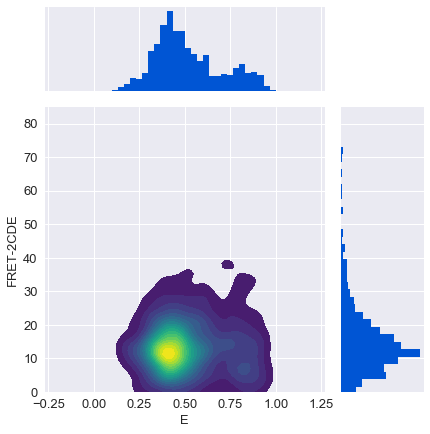

In [17]:
valid = np.isfinite(fret_2cde)
print('Number of bursts (removing NaNs/Infs):', valid.sum())
g = sns.JointGrid(x=ds.E[0][valid], y=fret_2cde[valid], ratio=3)
#g = g.plot_joint(plt.hexbin, **{'cmap': 'viridis', 'mincnt': 1, 'gridsize': 40})
g = g.plot_joint(sns.kdeplot, cmap='viridis', shade=True, shade_lowest=False, n_levels=20)
_ = g.ax_marg_x.hist(ds.E[0][valid], bins=np.arange(-0.2, 1.2, 0.0333))
_ = g.ax_marg_y.hist(fret_2cde[valid], bins=40, orientation="horizontal")
g.ax_joint.set_xlabel('E')
g.ax_joint.set_ylabel('FRET-2CDE');
g.ax_joint.set_ylim(0);

Number of bursts (removing NaNs/Infs): 1488


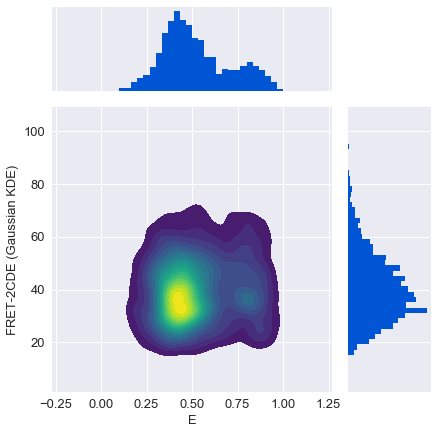

In [18]:
valid = np.isfinite(fret_2cde_gauss)
print('Number of bursts (removing NaNs/Infs):', valid.sum())
g = sns.JointGrid(x=ds.E[0][valid], y=fret_2cde_gauss[valid], ratio=3)
#g = g.plot_joint(plt.hexbin, **{'cmap': 'viridis', 'mincnt': 1, 'gridsize': 40})
g = g.plot_joint(sns.kdeplot, cmap='viridis', shade=True, shade_lowest=False, n_levels=20)
_ = g.ax_marg_x.hist(ds.E[0][valid], bins=np.arange(-0.2, 1.2, 0.0333))
_ = g.ax_marg_y.hist(fret_2cde_gauss[valid], bins=40, orientation="horizontal")
g.ax_joint.set_xlabel('E')
g.ax_joint.set_ylabel('FRET-2CDE (Gaussian KDE)');

Number of bursts (removing NaNs/Infs): 836


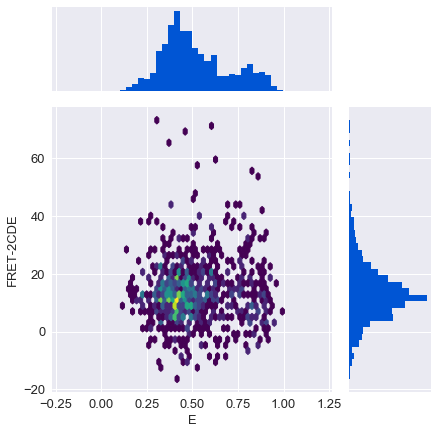

In [19]:
valid = np.isfinite(fret_2cde)
print('Number of bursts (removing NaNs/Infs):', valid.sum())
g = sns.JointGrid(x=ds.E[0][valid], y=fret_2cde[valid], ratio=3)
g = g.plot_joint(plt.hexbin, **{'cmap': 'viridis', 'mincnt': 1, 'gridsize': 40})
#g = g.plot_joint(sns.kdeplot, cmap='viridis', shade=True, shade_lowest=False)
_ = g.ax_marg_x.hist(ds.E[0][valid], bins=np.arange(-0.2, 1.2, 0.0333))
_ = g.ax_marg_y.hist(fret_2cde[valid], bins=40, orientation="horizontal")
g.ax_joint.set_xlabel('E')
g.ax_joint.set_ylabel('FRET-2CDE');

Number of bursts (removing NaNs/Infs): 1488


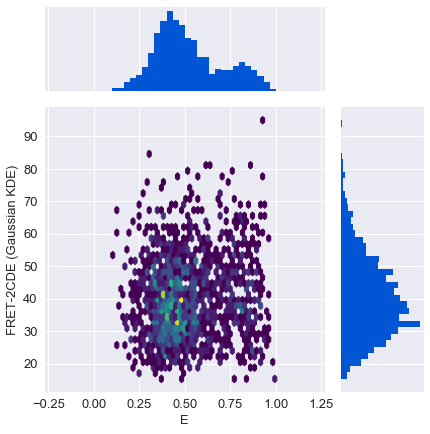

In [20]:
valid = np.isfinite(fret_2cde_gauss)
print('Number of bursts (removing NaNs/Infs):', valid.sum())
g = sns.JointGrid(x=ds.E[0][valid], y=fret_2cde_gauss[valid], ratio=3)
g = g.plot_joint(plt.hexbin, **{'cmap': 'viridis', 'mincnt': 1, 'gridsize': 40})
#g = g.plot_joint(sns.kdeplot, cmap='viridis', shade=True, shade_lowest=False)
_ = g.ax_marg_x.hist(ds.E[0][valid], bins=np.arange(-0.2, 1.2, 0.0333))
_ = g.ax_marg_y.hist(fret_2cde_gauss[valid], bins=40, orientation="horizontal")
g.ax_joint.set_xlabel('E')
g.ax_joint.set_ylabel('FRET-2CDE (Gaussian KDE)');

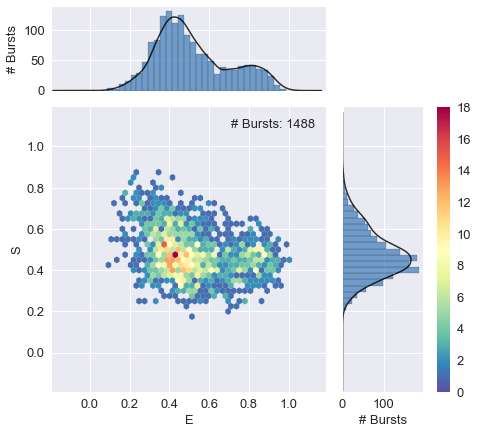

In [21]:
alex_jointplot(ds);

## ALEX-2CDE Definition

To compute ALEX-2CDE we need to define ([Tomov 2012, eq. 10](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$BR_{D_{EX}} = \frac{1}{ N_{CHA_{EX}} } 
\sum_{i=1}^{N_{CHD_{EX}}} \frac{ KDE_{D_{EX}i}^A }{ KDE_{D_{EX}i}^D }$$

and the analogous ([Tomov 2012, eq. 11](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$BR_{A_{EX}} = \frac{1}{ N_{CHD_{EX}} } 
\sum_{i=1}^{N_{CHA_{EX}}} \frac{ KDE_{A_{EX}i}^D }{ KDE_{A_{EX}i}^A }$$

Finally, *ALEX-2CDE* is defined as ([Tomov 2012, eq. 12](http://dx.doi.org/10.1016%2Fj.bpj.2011.11.4025)):

$$ ALEX-2CDE \left( t_{CHD}, t_{CHA} \right) = 
110 - 50 \cdot \left[ BR_{D_{EX}} + BR_{A_{EX}} \right]
$$


## ALEX-2CDE Implementation

In [22]:
bursts = ds1.mburst[0]

In [23]:
ph_dex = d.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
ph_aex = d.get_ph_times(ph_sel=Ph_sel(Aex='Aem'))

mask_dex = d.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))
mask_aex = d.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))

KDE_DexTi = phrates.kde_laplace(ph_dex, tau, time_axis=ph)
KDE_AexTi = phrates.kde_laplace(ph_aex, tau, time_axis=ph)

ALEX_2CDE = []
BRDex, BRAex = [], []
for ib, burst in enumerate(bursts):
    burst_slice = slice(int(burst.istart), int(burst.istop) + 1)
    if ~mask_dex[burst_slice].any() or ~mask_aex[burst_slice].any():
        # Either D or A photon stream has no photons in current burst, 
        # thus ALEX_2CDE cannot be computed.
        ALEX_2CDE.append(np.nan)
        continue

    kde_dexdex = KDE_DexTi[burst_slice][mask_dex[burst_slice]]
    kde_aexdex = KDE_AexTi[burst_slice][mask_dex[burst_slice]]
    N_chaex = mask_aex[burst_slice].sum()
    BRDex.append(np.sum(kde_aexdex / kde_dexdex) / N_chaex)
    
    kde_aexaex = KDE_AexTi[burst_slice][mask_aex[burst_slice]]
    kde_dexaex = KDE_DexTi[burst_slice][mask_aex[burst_slice]]
    N_chdex = mask_dex[burst_slice].sum()
    BRAex.append(np.sum(kde_dexaex / kde_aexaex) / N_chdex)
    
    alex_2cde = 100 - 50*(BRDex[-1] - BRAex[-1])
    ALEX_2CDE.append(alex_2cde)
ALEX_2CDE = np.array(ALEX_2CDE)

In [24]:
ALEX_2CDE.size, np.isfinite(ALEX_2CDE).sum(), np.isfinite(ds1.E[0]).sum()

(2859, 2656, 2859)

And some final plots of *ALEX-2CDE*:

Number of bursts (removing NaNs/Infs): 2656


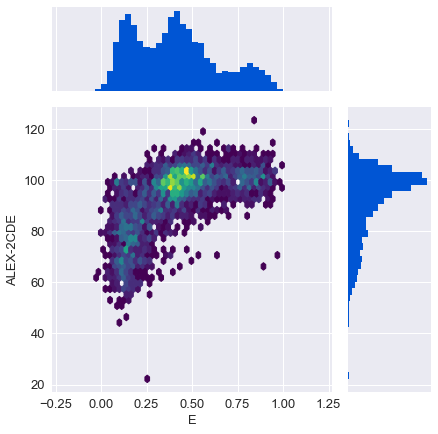

In [25]:
valid = np.isfinite(ALEX_2CDE)
print('Number of bursts (removing NaNs/Infs):', valid.sum())
g = sns.JointGrid(x=ds1.E[0][valid], y=ALEX_2CDE[valid], ratio=3)
g = g.plot_joint(plt.hexbin, **{'cmap': 'viridis', 'mincnt': 1, 'gridsize': 40})
_ = g.ax_marg_x.hist(ds1.E[0][valid], bins=np.arange(-0.2, 1.2, 0.0333))
_ = g.ax_marg_y.hist(ALEX_2CDE[valid], bins=40, orientation="horizontal")
g.ax_joint.set_xlabel('E')
g.ax_joint.set_ylabel('ALEX-2CDE');

Number of bursts (removing NaNs/Infs): 2656


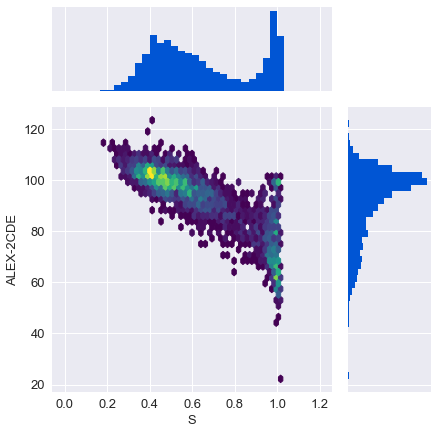

In [26]:
valid = np.isfinite(ALEX_2CDE)
print('Number of bursts (removing NaNs/Infs):', valid.sum())
g = sns.JointGrid(x=ds1.S[0][valid], y=ALEX_2CDE[valid], ratio=3)
g = g.plot_joint(plt.hexbin, **{'cmap': 'viridis', 'mincnt': 1, 'gridsize': 40})
_ = g.ax_marg_x.hist(ds1.S[0][valid], bins=np.arange(0, 1.2, 0.0333))
_ = g.ax_marg_y.hist(ALEX_2CDE[valid], bins=40, orientation="horizontal")
g.ax_joint.set_xlabel('S')
g.ax_joint.set_ylabel('ALEX-2CDE');

In [27]:
masks = [valid * (ALEX_2CDE > 88) * (ds1.S[0] > 0.9)]
ds2 = ds1.select_bursts_mask_apply(masks)

/Users/anto/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


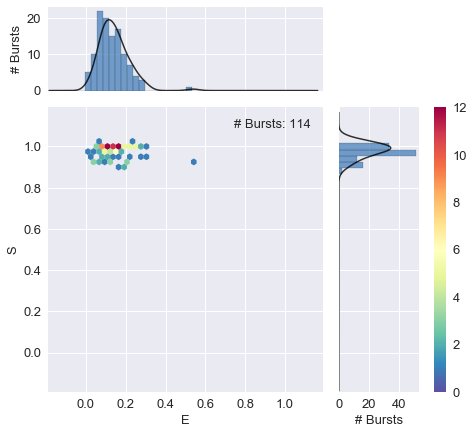

In [28]:
alex_jointplot(ds2, vmax_fret=False)